In [49]:
# Code for deep recurrent Q learning
# Paper: Deep Recurrent Q-Learning for Partially Observable MDPs
# Paper url: https://arxiv.org/pdf/1507.06527.pdf

import gym, random, pickle, os.path, math, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb
import os

from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

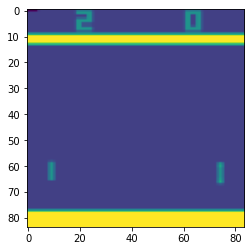

In [50]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

# plt.imshow(env.render("rgb_array"))
# env.close()

In [51]:
class DRQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5, device = torch.device("cpu")):
        """
        Initialize a deep Q-learning network as described in
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
            device: cpu or gpu (cuda:0)
        """
        super(DRQN, self).__init__()
        self.device = device
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.gru = nn.GRU(512, num_actions, batch_first=True) # input shape (batch, seq, feature)

    def forward(self, x, hidden = None, max_seq = 1, batch_size=1):
        # DQN input B*C*feature (32 4 84 84)
        # DRQN input B*C*feature (32*seq_len 4 84 84)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.reshape(x.size(0), -1)))
        hidden = self.init_hidden(batch_size) if hidden is None else hidden
        # before go to RNN, reshape the input to (barch, seq, feature)
        x = x.reshape(batch_size, max_seq, 512)
        return self.gru(x, hidden)

    def init_hidden(self, batch_size):
        # initialize hidden state to 0
        return torch.zeros(1, batch_size, self.num_actions, device= self.device, dtype=torch.float)


In [52]:
class Recurrent_Memory_Buffer(object):
    # memory buffer to store episodic memory
    def __init__(self, memory_size=1000, max_seq = 10):
        self.buffer = []
        self.memory_size = memory_size
        self.max_seq = max_seq
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        # sample episodic memory
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            finish = random.randint(self.max_seq, self.size() - 1)
            begin = finish-self.max_seq
            
            data = self.rec_memory_buffer.buffer[begin:finish]
            state, action, reward, next_state, done= zip(*data)
            states.append(np.concatenate([self.observe(state_i) for state_i in state]))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.concatenate([self.observe(state_i) for state_i in next_state]))
            dones.append(done)

        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [3]:
class DRQNAgent: 
    # DRQN agent
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4, max_seq = 10, batch_size = 32):
        self.USE_CUDA = USE_CUDA
        self.device = torch.device("cuda:0" if USE_CUDA else "cpu")
        self.max_seq = max_seq
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.action_space = action_space
        self.rec_memory_buffer = Recurrent_Memory_Buffer(memory_size)
        self.DRQN = DRQN(in_channels = in_channels, num_actions = action_space.n, device = self.device)
        self.DRQN_target = DRQN(in_channels = in_channels, num_actions = action_space.n, device = self.device)
        self.DRQN_target.load_state_dict(self.DRQN.state_dict())

        if USE_CUDA:
            self.DRQN = self.DRQN.cuda()
            self.DRQN_target = self.DRQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DRQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state, hidden = None):
        # get q_values of a given state
        q_values, hidden = self.DRQN(state, hidden)
        return q_values, hidden
    
    def act(self, state, hidden = None, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon
        q_values, hidden  = self.value(state, hidden)
        q_values = q_values.squeeze(0).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton, hidden
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only."""
        actions = torch.tensor(actions).long().flatten()    # shape: [batch_size * seq_len]
        rewards = torch.tensor(rewards, dtype =torch.float).flatten()  # shape: [batch_size * seq_len]
        is_done = torch.tensor(is_done).bool().flatten()  # shape: [batch_size * seq_len]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues, hidden = self.DRQN(states, batch_size = self.batch_size, max_seq = self.max_seq)
        predicted_qvalues = predicted_qvalues.reshape(-1, self.action_space.n)
        predicted_qvalues = predicted_qvalues.squeeze(0)
        
        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues, hidden_target = self.DRQN_target(next_states, batch_size = self.batch_size, max_seq = self.max_seq) # YOUR CODE
        predicted_next_qvalues = predicted_next_qvalues.squeeze(0)
        predicted_next_qvalues = predicted_next_qvalues.reshape(-1, self.action_space.n)

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] 

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values 

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        # rewriten sample() in buffer with pytorch operations
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        for i in range(batch_size):
            finish = random.randint(self.max_seq, self.rec_memory_buffer.size() - 1)
            begin = finish-self.max_seq
            
            data = self.rec_memory_buffer.buffer[begin:finish]
            state, action, reward, next_state, done= zip(*data)
            states.append(torch.cat([self.observe(state_i) for state_i in state]))
            actions.append(action)
            rewards.append(reward)
            next_states.append(torch.cat([self.observe(state_i) for state_i in next_state]))
            dones.append(done)

        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        # learn from experience
        if self.rec_memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DRQN.parameters():
                # clip the gradient
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [ ]:
# Training DRQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99 # discount factor
epsilon_max = 1 # epsilon greedy parameter max
epsilon_min = 0.01 # epsilon greedy parameter min
eps_decay = 30000 # epsilon greedy parameter decay
frames = 1000000 # total training frames
USE_CUDA = True # training with gpu
learning_rate = 2e-4 # learning rate
max_buff = 100000 # maximum buffer size
update_tar_interval = 1000 # frames for updating target network
batch_size = 32 
max_seq = 8

print_interval = 1000 
log_interval = 1000
learning_start = 5000 # 10000

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = DRQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate, max_seq = max_seq, batch_size = batch_size)
frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
# tensorboard
summary_writer = SummaryWriter(log_dir = "DRQN", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

hidden = None # initialize hidden state to None
for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action, hidden = agent.act(state_tensor, hidden, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.rec_memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.rec_memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DRQN_target.load_state_dict(agent.DRQN.state_dict())
    
    if done:

        frame = env.reset()
        hidden = None # reset hidden to None
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0
frames:  1000, reward: -21.000000, loss: 0.000000, epsilon: 0.967544, episode:    1
frames:  2000, reward: -20.000000, loss: 0.000000, epsilon: 0.936152, episode:    2
frames:  3000, reward: -20.000000, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -20.250000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.000000, loss: 0.021156, epsilon: 0.848017, episode:    5
frames:  6000, reward: -19.833333, loss: 0.011389, epsilon: 0.820543, episode:    6
frames:  7000, reward: -20.000000, loss: 0.007602, epsilon: 0.793971, episode:    7
frames:  8000, reward: -20.000000, loss: 0.007895, epsilon: 0.768269, episode:    8
frames:  9000, reward: -20.200000, loss: 0.007752, epsilon: 0.743410, episode:   10
frames: 10000, reward: -20.200000, loss: 0.009361, epsilon: 0.719366, episode:   11
frames: 11000, reward: -20.300000, loss: 0.011069, epsilon: 0.696110, episode:   

frames: 98000, reward: -16.500000, loss: 0.003315, epsilon: 0.047752, episode:   82
frames: 99000, reward: -16.500000, loss: 0.003370, epsilon: 0.046514, episode:   82
frames: 100000, reward: -15.300000, loss: 0.002055, epsilon: 0.045317, episode:   83
frames: 101000, reward: -15.300000, loss: 0.002854, epsilon: 0.044159, episode:   83
frames: 102000, reward: -15.000000, loss: 0.000711, epsilon: 0.043040, episode:   84
frames: 103000, reward: -14.700000, loss: 0.000445, epsilon: 0.041956, episode:   85
frames: 104000, reward: -14.700000, loss: 0.001948, epsilon: 0.040909, episode:   85
frames: 105000, reward: -15.000000, loss: 0.001191, epsilon: 0.039895, episode:   86
frames: 106000, reward: -15.000000, loss: 0.003230, epsilon: 0.038915, episode:   86
frames: 107000, reward: -15.200000, loss: 0.000588, epsilon: 0.037967, episode:   87
frames: 108000, reward: -15.200000, loss: 0.000731, epsilon: 0.037050, episode:   87
frames: 109000, reward: -14.800000, loss: 0.001891, epsilon: 0.0361

frames: 195000, reward: -12.300000, loss: 0.000304, epsilon: 0.011488, episode:  124
frames: 196000, reward: -12.300000, loss: 0.001699, epsilon: 0.011440, episode:  124
frames: 197000, reward: -12.300000, loss: 0.000275, epsilon: 0.011392, episode:  125
frames: 198000, reward: -12.300000, loss: 0.001613, epsilon: 0.011347, episode:  125
frames: 199000, reward: -12.300000, loss: 0.001569, epsilon: 0.011303, episode:  125
frames: 200000, reward: -12.700000, loss: 0.001021, epsilon: 0.011260, episode:  126
frames: 201000, reward: -12.700000, loss: 0.000621, epsilon: 0.011219, episode:  126
frames: 202000, reward: -12.900000, loss: 0.001756, epsilon: 0.011179, episode:  127
frames: 203000, reward: -12.900000, loss: 0.001595, epsilon: 0.011140, episode:  127
frames: 204000, reward: -12.900000, loss: 0.000179, epsilon: 0.011103, episode:  127
frames: 205000, reward: -12.900000, loss: 0.000375, epsilon: 0.011066, episode:  128
frames: 206000, reward: -12.900000, loss: 0.001476, epsilon: 0.01

In [2]:
##### def plot_training(frame_idx, rewards, losses):
clear_output(True)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
plt.plot(rewards)
plt.subplot(132)
plt.title('loss')
plt.plot(losses)
plt.show()

plot_training(i, all_rewards, losses)

NameError: name 'clear_output' is not defined